<a href="https://colab.research.google.com/github/DiploDatos/AprendizajeProfundo/blob/master/6_rnns.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Redes Neuronales Recurrentes

En esta notebook veremos cómo construir una red neuronal recurrente para el problema de clasificación de texto con el conjunto de datos IMDB reviews.


In [1]:
# If running in colab, you need to update gensim
# !pip install --upgrade gensim

In [2]:
import csv
import functools
import gzip
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import tempfile
import seaborn


from gensim import corpora
from gensim.models import KeyedVectors
from gensim.parsing import preprocessing
from gensim.scripts.glove2word2vec import glove2word2vec
from sklearn import metrics
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, IterableDataset
from tqdm.notebook import tqdm, trange


In [3]:
# Ensure version 4.X
import gensim
gensim.__version__

'4.2.0'

## Parte 1: Preprocesamiento del texto

Primero leeremos el dataset como se explica en la notebook 5_cnns.ipynb.

In [4]:
# If necessary, download data
# %%bash
# mkdir data
# curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/glove.6B.50d.txt.gz -o ./data/glove.6B.50d.txt.gz
# curl -L https://cs.famaf.unc.edu.ar/\~ccardellino/resources/diplodatos/imdb_reviews.csv.gz -o ./data/imdb_reviews.csv.gz

In [5]:
class IMDBReviewsDataset(Dataset):
    def __init__(self, dataset, transform=None):
        self.dataset = dataset
        self.transform = transform
    
    def __len__(self):
        return self.dataset.shape[0]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.to_list()
        
        item = {
            "data": self.dataset.loc[item, "review"],
            "target": self.dataset.loc[item, "sentiment"]
        }
        
        if self.transform:
            item = self.transform(item)
        
        return item

class RawDataProcessor:
    def __init__(self, 
                 dataset, 
                 ignore_header=True, 
                 filters=None, 
                 vocab_size=50000):
        if filters:
            self.filters = filters
        else:
            self.filters = [
                lambda s: s.lower(),
                preprocessing.strip_tags,
                preprocessing.strip_punctuation,
                preprocessing.strip_multiple_whitespaces,
                preprocessing.strip_numeric,
                preprocessing.remove_stopwords,
                preprocessing.strip_short,
            ]
        
        # Create dictionary based on all the reviews (with corresponding preprocessing)
        self.dictionary = corpora.Dictionary(
            dataset["review"].map(self._preprocess_string).tolist()
        )
        # Filter the dictionary and compactify it (make the indices continous)
        self.dictionary.filter_extremes(no_below=2, no_above=1, keep_n=vocab_size)
        self.dictionary.compactify()
        # Add a couple of special tokens
        self.dictionary.patch_with_special_tokens({
            "[PAD]": 0,
            "[UNK]": 1
        })
        self.idx_to_target = sorted(dataset["sentiment"].unique())
        self.target_to_idx = {t: i for i, t in enumerate(self.idx_to_target)}

    def _preprocess_string(self, string):
        return preprocessing.preprocess_string(string, filters=self.filters)

    def _sentence_to_indices(self, sentence):
        return self.dictionary.doc2idx(sentence, unknown_word_index=1)
    
    def encode_data(self, data):
        return self._sentence_to_indices(self._preprocess_string(data))
    
    def encode_target(self, target):
        return self.target_to_idx[target]
    
    def __call__(self, item):
        if isinstance(item["data"], str):
            data = self.encode_data(item["data"])
        else:
            data = [self.encode_data(d) for d in item["data"]]
        
        if isinstance(item["target"], str):
            target = self.encode_target(item["target"])
        else:
            target = [self.encode_target(t) for t in item["target"]]
        
        return {
            "data": data,
            "target": target,
            "sentence": item["data"]
        }

In [6]:
dataset = pd.read_csv("./data/imdb_reviews.csv.gz")
preprocess = RawDataProcessor(dataset)
train_indices, test_indices = train_test_split(dataset.index, test_size=0.2, random_state=42)
train_dataset = IMDBReviewsDataset(dataset.loc[train_indices].reset_index(drop=True), transform=preprocess)
test_dataset = IMDBReviewsDataset(dataset.loc[test_indices].reset_index(drop=True), transform=preprocess)

In [7]:
print("Sample element:")
print(train_dataset[1]['sentence'])
print(f"\tTotal {len(train_dataset[1]['data'])} words ")
print("\tSentiment", train_dataset[1]['target'])

Sample element:
I did not watch the entire movie. I could not watch the entire movie. I stopped the DVD after watching for half an hour and I suggest anyone thinking of watching themselves it stop themselves before taking the disc out of the case.<br /><br />I like Mafia movies both tragic and comic but Corky Romano can only be described as a tragic attempt at a mafia comedy.<br /><br />The problem is Corky Romano simply tries too hard to get the audience to laugh, the plot seems to be an excuse for moving Chris Kattan (Corky) from one scene to another. Corky himself is completely overplayed and lacks subtlety or credulity - all his strange mannerisms come across as contrived - Chris Kattan is clearly 'acting' rather than taking a role - it bounces you right out of the story. Each scene is utterly predictable, the 'comedic event' that will occur on the set is obvious as soon as each scene is introduced. In comedies such as Mr. Bean the disasters caused by the title character are funny 

In [8]:
class PadSequences:
    def __init__(self, pad_value=0, max_length=100):
        self.pad_value = pad_value
        self.max_length = max_length

    def __call__(self, items):
        data, target = list(zip(*[(item["data"], item["target"]) for item in items]))
        seq_lengths = [len(d) for d in data]

        max_length = self.max_length
        seq_lengths = [min(self.max_length, l) for l in seq_lengths]

        data = [d[:l] + [self.pad_value] * (max_length - l)
                for d, l in zip(data, seq_lengths)]
            
        return {
            "data": torch.LongTensor(data),
            "target": torch.FloatTensor(target)
        }

In [9]:
EPOCHS = 2
MAX_SEQUENCE_LEN = 100

pad_sequences = PadSequences(max_length=MAX_SEQUENCE_LEN)
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True,
                          collate_fn=pad_sequences, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False,
                         collate_fn=pad_sequences, drop_last=False)


* ¿A qué corresponde cada dimensión?

In [10]:
iter(train_loader).next()['data'].shape

torch.Size([128, 100])

## Parte 2: Esqueleto de la red neuronal

Lo primero que debemos pensar es cómo será la arquitectura de nuestra red para resolver la tarea deseada. En esta sección crearemos el modelo sequencial con PyTorch que representará nuestra red. 

Para poder implementar el modelo debemos responder las siguientes preguntas:
  - ¿Es una red one-to-one, one-to-many, many-to-one o many-to-many?
  - ¿Cuál es el formato de entrada y de salida de la red? ¿Cuál es el tamaño de las matrices (tensores) de entrada y de salida?
  - Luego de que la entrada pasa por la capa recurrente, ¿qué tamaño tiene el tensor?
  - ¿Cómo se conecta la salida de la capa recurrente con la capa densa que realiza la clasificación?
  - ¿Cuál es el loss apropiado para este problema?

Primero importamos los módulos que necesitaremos para implementar nuestra red:
  - torch: acceso a todo el framework
  - torch.nn: nos da acceso a capas ya implementadas y a la clase Module para instanciar y crear nuestra red
  

In [11]:
import torch
import torch.nn as nn

# Check if we have a GPU available
use_cuda = torch.cuda.is_available()
device = torch.device('cuda') if use_cuda else torch.device('cpu')

In [12]:
class ImdbLSTM(nn.Module):
    def __init__(self,
                 pretrained_embeddings_path, dictionary, embedding_size,
                 hidden_layer=32,
                 num_layers=1, dropout=0., bias=True,
                 bidirectional=False,
                 freeze_embedings=True):
        
        super(ImdbLSTM, self).__init__()
        output_size = 1
        # Create the Embeddings layer and add pre-trained weights
        embeddings_matrix = torch.randn(len(dictionary), embedding_size)
        embeddings_matrix[0] = torch.zeros(embedding_size)
        with gzip.open(pretrained_embeddings_path, "rt") as fh:
            for line in fh:
                word, vector = line.strip().split(None, 1)
                if word in dictionary.token2id:
                    embeddings_matrix[dictionary.token2id[word]] =\
                        torch.FloatTensor([float(n) for n in vector.split()])
        self.embedding_config = {'freeze': freeze_embedings,
                                  'padding_idx': 0}
        self.embeddings = nn.Embedding.from_pretrained(
            embeddings_matrix, **self.embedding_config)
        
        # Set our LSTM parameters
        self.lstm_config = {'input_size': embedding_size,
                            'hidden_size': hidden_layer,
                            'num_layers': num_layers,
                            'bias': bias,
                            'batch_first': True,
                            'dropout': dropout,
                            'bidirectional': bidirectional}
        
        # Set our fully connected layer parameters
        self.linear_config = {'in_features': hidden_layer,
                              'out_features': output_size,
                              'bias': bias}
        
        # Instanciate the layers
        self.lstm = nn.LSTM(**self.lstm_config)
        self.classification_layer = nn.Linear(**self.linear_config)
        self.activation = nn.Sigmoid()

    def forward(self, inputs):
        emb = self.embeddings(inputs)
        # print(emb.shape)
        lstm_out, _ = self.lstm(emb)
        # print(lstm_out.shape)
        # Take last state of lstm, which is a representation of
        # the entire text
        lstm_out = lstm_out[:, -1, :].squeeze()
        # print(lstm_out.shape)
        predictions = self.activation(self.classification_layer(lstm_out))
        # print(prediction.shape)
        return predictions

In [13]:
model = ImdbLSTM(
    "./data/glove.6B.50d.txt.gz", preprocess.dictionary,
    embedding_size=50,
    hidden_layer=64,
    num_layers=1,
    dropout=0.1
)
print(model)

ImdbLSTM(
  (embeddings): Embedding(50002, 50, padding_idx=0)
  (lstm): LSTM(50, 64, batch_first=True, dropout=0.1)
  (classification_layer): Linear(in_features=64, out_features=1, bias=True)
  (activation): Sigmoid()
)


/home/adrian/PycharmProjects/AprendizajeProfundo/venv/lib/python3.10/site-packages/torch/nn/modules/rnn.py:62: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


Aplicaremos el modelo sin entrenar a un batch de ejemplos y graficaremos la distribución de los scores obtenidos.

In [14]:
example_batch = iter(train_loader).next()
preds = model(example_batch['data'])  # Predictions for an entire batch
preds = [x[0] for x in preds.tolist()]
len(preds)

128

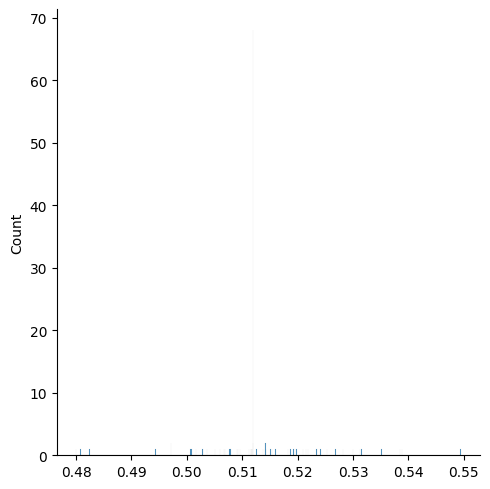

In [15]:
seaborn.displot(preds)

## Parte 3: Entrenamiento de la red

En esta sección entrenaremos nuestra red. Primero configuramos los hiperparámetros de la red. En este momento determinamos lo siguiente:
  -  learning_rate
  -  epochs
  -  función de pérdida
  -  optimizador
  
También definimos los parámetros para torch.DataLoader, clase que implementa un manejador del dataset que nos dividirá los datos en batches (y los distribuirá entre distintos nodos de cómputo, en caso de contar con multi GPU).

In [16]:
import torch.optim as optim

learning_rate = 0.001
EPOCHS = 5
loss_function = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), learning_rate)

# Don't forget to send the model to GPU if there is one available

In [17]:
history = {
    'train_loss': [],
    'test_loss': [],
    'test_avp': []
}
for epoch in trange(EPOCHS):
  model.train()
  running_loss = []
  print("Epoch", epoch)
  for idx, batch in enumerate(tqdm(train_loader)):
      optimizer.zero_grad()
      output = model(batch["data"])
      loss_value = loss_function(output.squeeze(), batch["target"])
      loss_value.backward()
      optimizer.step()
      running_loss.append(loss_value.item())
  train_loss = sum(running_loss) / len(running_loss)
  print("\t Final train_loss", train_loss)
  history['train_loss'].append(train_loss)
  
  model.eval()
  running_loss = []
  targets = []
  predictions = []
  for batch in tqdm(test_loader):
      output = model(batch["data"])
      running_loss.append(
          loss_function(output.squeeze(), batch["target"]).item()
      )
      targets.extend(batch["target"].numpy())
      # Round up model output to get the predictions.
      # What would happen if you change the activation to tanh?
      predictions.extend(output.squeeze().round().detach().numpy())
  test_loss = sum(running_loss) / len(running_loss)
  avp = metrics.average_precision_score(targets, predictions)
  print("\t Final test_loss", test_loss)
  print("\t Final test_avp", avp)
  history['test_loss'].append(test_loss)
  history['test_avp'].append(avp)

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch 0


  0%|          | 0/313 [00:00<?, ?it/s]

	 Final train_loss 0.6802762923910975


  0%|          | 0/79 [00:00<?, ?it/s]

	 Final test_loss 0.6908906283257883
	 Final test_avp 0.5123471100102742
Epoch 1


  0%|          | 0/313 [00:00<?, ?it/s]

	 Final train_loss 0.6709047127455569


  0%|          | 0/79 [00:00<?, ?it/s]

	 Final test_loss 0.6571739964847323
	 Final test_avp 0.5879807280888876
Epoch 2


  0%|          | 0/313 [00:00<?, ?it/s]

	 Final train_loss 0.5828955435333922


  0%|          | 0/79 [00:00<?, ?it/s]

	 Final test_loss 0.5351735044129288
	 Final test_avp 0.7029293241686806
Epoch 3


  0%|          | 0/313 [00:00<?, ?it/s]

	 Final train_loss 0.4838183192780223


  0%|          | 0/79 [00:00<?, ?it/s]

	 Final test_loss 0.45980498647388024
	 Final test_avp 0.7351315266261303
Epoch 4


  0%|          | 0/313 [00:00<?, ?it/s]

	 Final train_loss 0.44067103822772113


  0%|          | 0/79 [00:00<?, ?it/s]

	 Final test_loss 0.43164197817633426
	 Final test_avp 0.745042277181074


## Ejercicios extras

Una vez que hemos implementado la arquitectura básica de la red, podemos comenzar a experimentar con distintas modificaciones para lograr mejores resultados. Algunas tareas posibles son:

 - Agregar más capas recurrentes
 - Probar otros largos de secuencias máximas
 - Agregar capas de regularización y/o dropout
 - Entrenar los embeddings junto con la red